In [144]:
import os
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering 
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy 
from sklearn.cluster import KMeans 


In [3]:
# Load file
aus_suburbs = pd.read_csv(os.path.join('aus_suburbs.csv'), index_col=0)

Yeo Johnson transformation

In [6]:
# Extract area, density, and distance columns to be transformed and standardised
temp_data = aus_suburbs[['area', 'density', 'distance']]

# Yeo-Johnson transformation
# Create the Scaler object
scaler = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

# Fit your data on the scaler object
yeojohnson = scaler.fit_transform(temp_data)

suburbs_info_yeojohnson = pd.DataFrame(yeojohnson, columns=temp_data.columns)

# Matrix standardisation
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
standardised = scaler.fit_transform(yeojohnson)

standardised = pd.DataFrame(standardised, columns=temp_data.columns)

# Add suburb and postcode labels to rows
geo_df = standardised
geo_df.insert(0, 'Suburb_id', aus_suburbs.Suburb_id)
geo_df.insert(1, 'Suburb', aus_suburbs.Suburb)
geo_df.insert(2, 'Postcode', aus_suburbs.Postcode)
geo_df.insert(3, 'LGA', aus_suburbs.LGA)
geo_df.insert(4, 'City', aus_suburbs.City)

PCA transformation

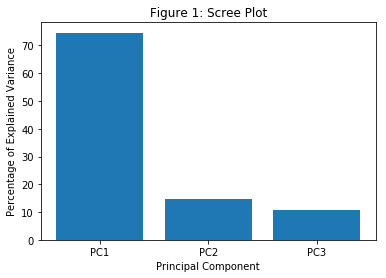

In [13]:
data = geo_df.drop(columns=['Suburb_id', 'Suburb', 'Postcode', 'LGA', 'City'], axis=1)

pca = PCA()
pca.fit(data)
pca_data = pca.transform(data)

percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(percentage_variation)+1)]

plt.bar(x=range(1,len(percentage_variation)+1), height=percentage_variation, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Figure 1: Scree Plot')
plt.show()

In [14]:
print('PC1: {}'.format(pca.explained_variance_ratio_[0]))
print('PC2: {}'.format(pca.explained_variance_ratio_[1]))
print('PC3: {}'.format(pca.explained_variance_ratio_[2]))

PC1: 0.7456481950490375
PC2: 0.14617058104948707
PC3: 0.10818122390147548


PC1 and PC2 together explain almost 90% of the variability of the data.

(-4, 4)

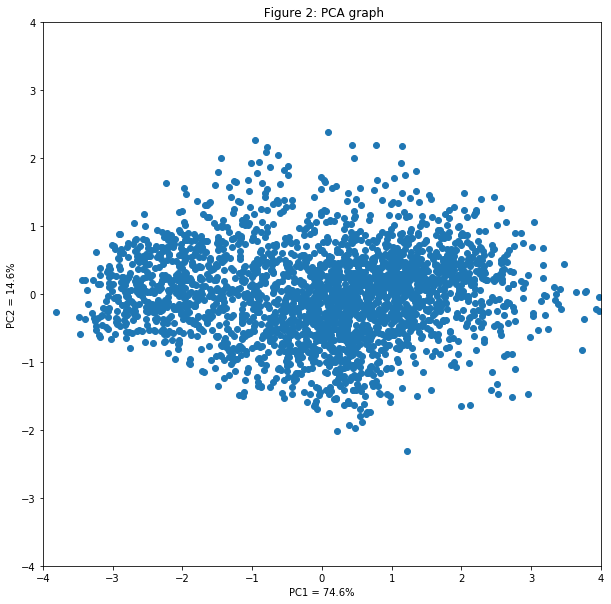

In [15]:
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title(' Figure 2: PCA graph')
plt.xlabel('PC1 = {}%'.format(percentage_variation[0]))
plt.ylabel('PC2 = {}%'.format(percentage_variation[1]))
plt.xlim(-4,4)
plt.ylim(-4,4)

In [16]:
# The normalised variance of each attribute for all three principle components.
pd.DataFrame(pca.components_,columns=data.columns,index = ['PC1','PC2','PC3'])

,area,density,distance
PC1,-0.589922,0.582163,-0.559533
PC2,0.295095,-0.489582,-0.820505
PC3,-0.751605,-0.649150,0.117022


In addition to PC1 having the most variation in regards to suburb area, density, and distance, all three attribuates for PC1 had roughly an equal influence on the distribution of the data. However, suburb area and density had a slight larger influence.

In [17]:
# Add suburb and postcode labels to rows
geo_df = pca_df
geo_df.insert(0, 'Suburb_id', aus_suburbs.Suburb_id)
geo_df.insert(1, 'Suburb', aus_suburbs.Suburb)
geo_df.insert(2, 'Postcode', aus_suburbs.Postcode)
geo_df.insert(3, 'LGA', aus_suburbs.LGA)
geo_df.insert(4, 'City', aus_suburbs.City)

# Drop PC3 column
geo_df.drop(columns='PC3', axis=1, inplace=True)

# Agglomerative Clustering

In [181]:
# Convert to array
pca_array = geo_df[['PC1', 'PC2']].to_numpy()

In [182]:
agglom = AgglomerativeClustering(n_clusters = 2, linkage = 'average')

In [183]:
agglom.fit(pca_array)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func='deprecated')

In [184]:
cluster_labels = agglom.labels_

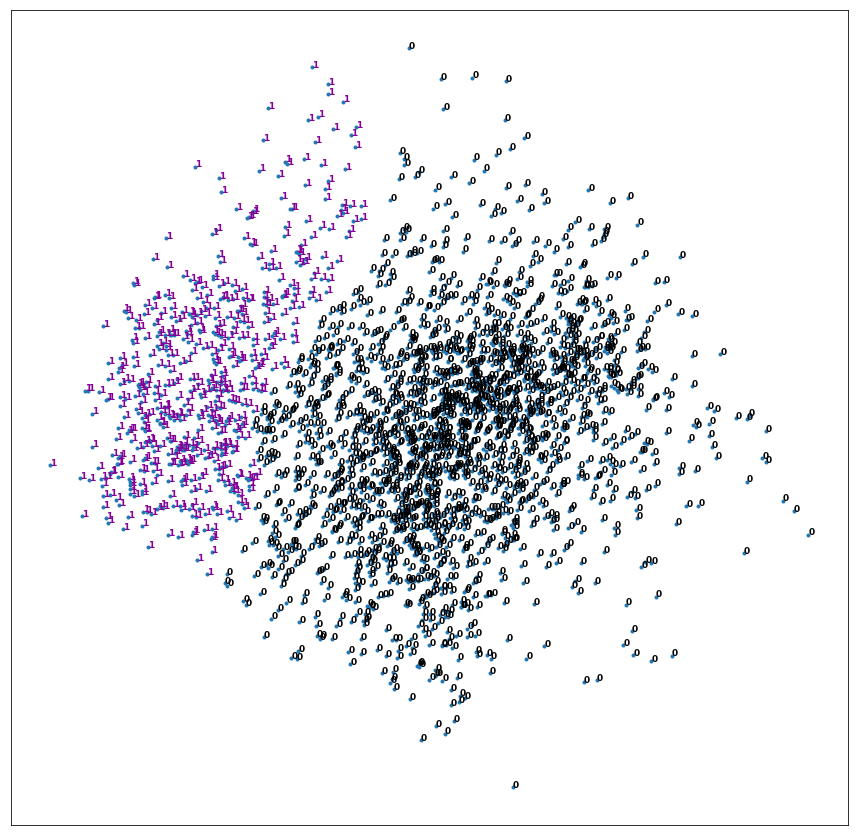

In [189]:
# Create a figure of size 15 inches by 15 inches.
plt.figure(figsize=(15,15))

# These two lines of code are used to scale the data points down,
# Or else the data points will be scattered very far apart.

# Create a minimum and maximum range of X1.
x_min, x_max = np.min(pca_array, axis=0), np.max(pca_array, axis=0)

# Get the average distance for X1.
pca_array = (pca_array - x_min) / (x_max - x_min)

# This loop displays all of the datapoints.
for i in range(pca_array.shape[0]):
    # Replace the data points with their respective cluster value 
    # (ex. 0) and is color coded with a colormap (plt.cm.spectral)
    plt.text(pca_array[i, 0], pca_array[i, 1], str(cluster_labels[i]),
             color=plt.cm.nipy_spectral(agglom.labels_[i] / 10.),
             fontdict={'weight': 'bold', 'size': 9})
    
# Remove the x ticks, y ticks, x and y axis
plt.xticks([])
plt.yticks([])
#plt.axis('off')



# Display the plot of the original data before clustering
plt.scatter(pca_array[:, 0], pca_array[:, 1], marker='.')
# Display the plot
plt.show()

Dendrogram Associated for the Agglomerative Hierarchical Clustering

In [186]:
dist_matrix = distance_matrix(pca_array,pca_array) 

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


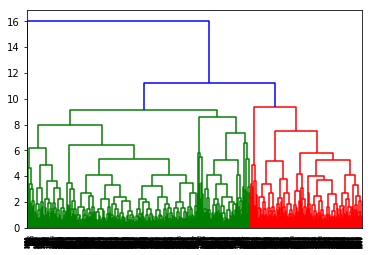

In [187]:
Z = hierarchy.linkage(dist_matrix, 'average')
dendro = hierarchy.dendrogram(Z)

# Label suburbs with cluster id

In [196]:
aus_suburbs_clustered = aus_suburbs[['Suburb_id', 'Suburb', 'Postcode', 'LGA', 'City', 'State', 'area', 'density', 'distance']]
aus_suburbs_clustered.insert(0, 'Cluster_Labels', cluster_labels)

In [198]:
aus_suburbs_clustered.head()

,Cluster_Labels,Suburb_id,Suburb,Postcode,LGA,City,State,area,density,distance
0,0,0,Abbotsbury,2176,City of Fairfield,Sydney,New South Wales,4.833,879.991724,31.895053
1,0,1,Abbotsford,2046,City of Canada Bay,Sydney,New South Wales,0.994,5405.432596,7.682393
2,0,2,Acacia Gardens,2763,City of Blacktown,Sydney,New South Wales,0.957,3968.652038,30.950468
3,1,3,Agnes Banks,2753,"City of Hawkesbury, City of Penrith",Sydney,New South Wales,15.723,57.940597,53.589220
4,0,4,Airds,2560,City of Campbelltown,Sydney,New South Wales,2.353,1243.518912,42.977938


In [206]:
cluster_1 = aus_suburbs_clustered.loc[aus_suburbs_clustered.Cluster_Labels == 0]
cluster_1.shape

(1992, 10)

In [207]:
cluster_2 = aus_suburbs_clustered.loc[aus_suburbs_clustered.Cluster_Labels == 1]
cluster_2.shape

(566, 10)

# Examine clusters

In [208]:
np.mean(cluster_1.area)

3.903605421686751

In [209]:
np.mean(cluster_2.area)

30.801975265017663

In [210]:
np.mean(cluster_1.density)

2244.0664537831685

In [211]:
np.mean(cluster_2.density)

73.02178954683416

In [212]:
np.mean(cluster_1.distance)

16.87363681824933

In [213]:
np.mean(cluster_2.distance)

37.40754627797614

Save file